# Finding gender by employees's name (UFRN)
by [Adriana Benício](https://github.com/adrianabenicio) and [Gisliany Alves](https://github.com/gisliany)

## Goal

The main goal of this project is analyze the gender gap between employees of UFRN. To do this, we'll scrape multiple web pages of [Portal da Transparência](http://www.portaldatransparencia.gov.br/) with Python using BeautifulSoup and requests libraries. The Portal da Transparência just provides the employee names, so we'll get the gender by the employee first name doing requisitions to an [IBGE](https://www.ibge.gov.br/) API.

## Gender Identification

The function <code>find_gender</code> was defined to discover the gender of each name in the list passed as parameter using the [IBGE API](https://servicodados.ibge.gov.br/api/docs/censos/nomes). This API informs the frequency of names by the decade of birth, from parameters such as name and gender. In this task, only the first names were used to determine the gender. 

Each first name was associated to a collection of equivalents names, which were obtained by replacing characters ('y' by 'e', for example) and also removing the duplicated ones. After, the IBGE API was called twice, one for each gender (F or M).

The equivalent name with highest frequency in the year 2010 was selected to determine the gender of the original name by comparing the frequency between the genders.

In [1]:
# necessary imports
from requests import get
from bs4 import BeautifulSoup
import json
import pandas as pd
from time import sleep
from random import randint
from time import time
from warnings import warn
from IPython.core.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

The function `choose_names` is called inside of `find_gender` and it's responsable for replacing the characters like 'y' by 'e' or 'k' by 'c'.

In [3]:
def choose_names(first_names):
    names_dict = {}
    
    for name in first_names:
        values = [name]

        # Remove duplicated characters
        add = False
        name_list = list(name)
        for i in range(0,len(name_list)):
            if i > 1 and name_list[i] == name_list[i-1]:
                name = name.replace(name_list[i]+name_list[i],name_list[i])
                add = True

        # Replace characters
        if add:
            values.append(name)
        if "y" in name:
            values.append(name.replace('y','e'))
            values.append(name.replace('y','i'))
        if "k" in name:
            values.append(name.replace('k','c'))
        if "w" in name:
            values.append(name.replace('w','v'))
            values.append(name.replace('w','u'))

        names_dict[values[0]] = values
    return names_dict

In [4]:
def find_gender(names):
    first_names = []
    for name in names: first_names.append(name.split()[0].lower())
    
    name_gender = {}
    names_dict = {}
    names_ibge_f = {}
    names_ibge_m = {}

    # Determines the names that will be queried to the API
    names_dict = choose_names(first_names)
    
    # Call IBGE API using each gender as parameter for the collection of names separated by '|'.
    # The frequency in the year 2010 was saved.
    query = ''
    for key, value in names_dict.items():
        for n in value:
            query = query + n + '|'

    url_f = 'http://servicodados.ibge.gov.br/api/v2/censos/nomes/{}?sexo=f'.format(query)
    url_m = 'http://servicodados.ibge.gov.br/api/v2/censos/nomes/{}?sexo=m'.format(query)

    response_f = get(url_f)
    response_m = get(url_m)

    json_f = json.loads(response_f.text)
    json_m = json.loads(response_m.text)

    for j in json_f:
        names_ibge_f[j.get('nome')] = j.get('res')[len(j.get('res'))-1].get('frequencia')
    for j in json_m:
        names_ibge_m[j.get('nome')] = j.get('res')[len(j.get('res'))-1].get('frequencia')

        
     # The highest frequency between equivalent names was selected to compare the frequency between the genders.
    for key, value in names_dict.items():
        f_count = 0;
        for v in value:
            if v.upper() in names_ibge_f.keys() and names_ibge_f[v.upper()] > f_count:
                f_count = names_ibge_f[v.upper()]

        m_count = 0;
        for v in value:
            if v.upper() in names_ibge_m.keys() and names_ibge_m[v.upper()] > m_count:
                m_count = names_ibge_m[v.upper()]

        if f_count > m_count:
            name_gender[key] = 'F'
        elif m_count > f_count:
            name_gender[key] = 'M'
        else:
            name_gender[key] = ''
        
    return name_gender

## Scraping multiple pages

We’ll build our multiple page script by doing three things:

- Making all the requests we want from within the loop.
- Controlling the loop’s rate to avoid bombarding the server with requests.
- Monitoring the loop while it runs.

We’ll scrape all pages (413 pages) that contains information about the employee names of UFRN. Each page has 15 lines (excluding the header) of target information, so we’ll theoretically scrape data for 6.185 names. But not all pages have 15 lines, the last one has just three names. Then, the total is actually 6.183 names.

In [5]:
pages = [str(i) for i in range(1, 414)] # generates a list with the page numbers (from 1 to 413)

In [7]:
# Lists to store the scraped data in
names = []
genders = []

# dict with the employee first name as key and his gender as value
gender_dict = {}

# Preparing the monitoring of the loop
start_time = time()
requests = 0

# For each page
for page in pages:
    # url of Portal da Transparência
    url = 'http://www.portaltransparencia.gov.br/servidores/OrgaoExercicio-ListaServidores.asp?CodOrg=26243&Pagina=' + page
        
    # Make a get request
    response = get(url)
    
    # Pause the loop for a random number of seconds
    sleep(randint(1, 3))
    
    # Monitor the requests
    requests += 1
    elapsed_time = time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    clear_output(wait = True)
              
    # Throw a warning for non-200 status codes
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
              
    # Break the loop if the number of requests is greater than expected
    if requests > 420:
        warn('Number of requests was greater than expected.')  
        break 
    
    # get the html
    html_soup = BeautifulSoup(response.text, 'html.parser')
    
    # information about the names is within a table element
    unit_table = html_soup.find_all('table')
    
    # the second one is the target
    unit_rows  = unit_table[1].find_all('tr')
    unit_rows = unit_rows[1:]
    
    # Extract data from individual rows
    for row in unit_rows:
    
        # employee names
        name = row.find('a').text
        names.append(name)
    
    # now, we do requests to the IBGE API. Here, the 'index' variable holds the first index associated to the first name
    # of the last requested table.
    index = ((requests - 1) * 15)
    
    # looping over the last 15 names and sending to IBGE API four names at a time.
    for i in range(0, len(names[index:])//4+1):
        gender_dict.update(find_gender(names[index:][i*4:(i+1)*4]))
        sleep(1)
    
# finally, we fill the genders list using the gender dictionary
for n in names:
    first_name = n.split()[0].lower()
    genders.append(gender_dict[first_name])

Request:413; Frequency: 0.12156032493045756 requests/s


After executing the script above, 284 employees did not have their gender identified from the first name.

In [8]:
genders.count('')

284

So, we get the employees first name, whose gender was not identified, and we generate a new dictionary with employee first name as key and a list of equivalent names as the value. In sequence, we send all the names to another API: the [Gender API](https://gender-api.com). To use this API, we create a free account and a private server key was given to us.

In [11]:
unknown_genders = [names[i].split()[0].lower() for i, v in enumerate(genders) if v == ''] # get all employees without a gender

names_options = []                           # list with all employee names, whose gender was not identified
names_dict = choose_names(unknown_genders)   # dictionqry with employee first name as key and a list of equivalent names as value

for i, lista in names_dict.items():
    names_options += lista
    
print(len(names_options))

467


In [12]:
# Preparing the monitoring of the loop
req = 0
start_time = time()

# list with the responses
gender_api = []

 # looping over the list of names and sending to Gender API 50 names at a time.
for i in range(0, len(names_options)//50 + 1):
    names_to_send = ';'.join(names_options[i*50 : (i+1)*50])
    
    url = 'https://gender-api.com/get?key=<your_key>&name={}='.format(names_to_send)
    response = get(url)
    
    # Pause the loop for a random number of seconds
    sleep(randint(3, 5))
    
    req += 1
    
    # Monitor the requests
    elapsed_time = time() - start_time
    print('Request:{}; Frequency: {} requests/s'.format(req, req/elapsed_time))
    clear_output(wait = True)
    
    # Break the loop if the number of requests is greater than expected
    if req > 12:
        warn('Number of requests was greater than expected.')  
        break
    
    # append the response to gender_api list
    gender_api += json.loads(response.text).get('result')

Request:10; Frequency: 0.18355565560767836 requests/s


Now, we verify the list of JSON objects returned by the Gender API. Each object has the following structure:

```json
{"name":"john","country":"BR","gender":"male","samples":1046,"accuracy":99,"duration":"29ms"}
```

Then, we'll iterate over the `names_dict` dictionary, compare each name into the list of values of this dictionary with the objects returned by the API and create a new list containing the genders (`genders_to_choose`). By the frequence of the gender into this new list, we'll choose the real gender that will be associated with the current key (real employee name) of `names_dict` in the loop.

In [13]:
nomes = [n.split()[0].lower() for n in names]  # all the lowercase first names

for name, list_of_names in names_dict.items(): # loop over name_dict (key: real employee name; value: list of equivalent names)
    genders_to_choose = []                     # list with the genders associated to the current list_of_names variable
    
    for l in gender_api:                       # iterate over the returned JSON objects
        if l['name'] in list_of_names:         # verify if the object name is in the current list_of_names
            genders_to_choose.append(l['gender'][0].upper())
    
    # The gender with the highest occurrence is chosen
    index = nomes.index(name)
    if genders_to_choose.count('F') > genders_to_choose.count('M'):
        genders[index] = 'F'
    elif genders_to_choose.count('F') < genders_to_choose.count('M'):
        genders[index] = 'M'
    else:
        genders[index] = ''

After executing the script above, 197 employees did not have their gender identified from the first name.

In [14]:
genders.count('')

197

Let’s check the data collected so far. Pandas makes it easy for us to see whether we’ve scraped our data successfully.

In [15]:
web_scraping_df = pd.DataFrame({'Name': names, 'Gender': genders})
print(web_scraping_df.info())
web_scraping_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6183 entries, 0 to 6182
Data columns (total 2 columns):
Gender    6183 non-null object
Name      6183 non-null object
dtypes: object(2)
memory usage: 96.7+ KB
None


,Gender,Name
0,M,ABDO FARRET NETO
1,M,ABMAEL BEZERRA DE OLIVEIRA
2,M,ABNER CARLOS COSTA DE MELO
3,M,ABRAHAO SANDERSON NUNES FERNANDES DA SILVA ...
4,F,ACACIA JESSICA MAIA DE MOURA
5,M,ACACIO MEDEIROS NOGUEIRA
6,F,ACILENE MARIA BORGES GOMES OLIVEIRA
7,F,ACSA NARA DE ARAUJO BRITO BARROS
8,,ACYNELLY DAFNE DA SILVA NUNES
9,F,ADA CRISTINA SCUDELARI


In [16]:
# witting a csv file
web_scraping_df.to_csv('employees_of_UFRN.csv')

## Plotting and analyzing the results

As we can see, the gender gap between the employees of UFRN is very small. Apparently, there are a few more men than women. However, since 197 employees (3.186 %) did not have their gender defined, it is possible that the gap is even smaller.

In [29]:
total = len(genders)

percentual_of_male = genders.count('M')/total
percentual_of_female = genders.count('F')/total
percentual_of_unknown = genders.count('')/total

print("Male: %.3f %%" % (percentual_of_male * 100))
print("Female: %.3f %%" % (percentual_of_female * 100))
print("Unknown: %.3f %%" % (percentual_of_unknown * 100))

Male: 49.830 %
Female: 46.984 %
Unknown: 3.186 %


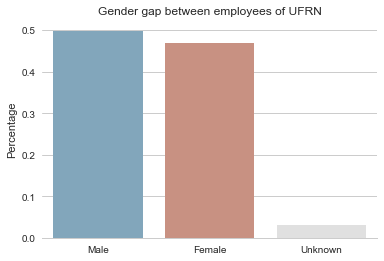

In [35]:
sns.set_style("whitegrid")
sns.set_context("notebook")

# axis
x = ['Male', 'Female', 'Unknown']
y = [percentual_of_male, percentual_of_female, percentual_of_unknown]

sns.barplot(x=x, y=y, palette=["#78a9c4", "#d48a76", "#e0e0e0"])
plt.title("Gender gap between employees of UFRN")
plt.ylabel("Percentage")

sns.despine(left=True)
plt.show()